# Repository Discovery

# Table of Contents
- [Introduction](#introduction)
- [Initial Setup](#setup)
- [Known Contributors](#known-contributors)
- [Event Analysis](#contribution-event-stream-analysis)
- [Known Contributor Event Analysis](#known-contributors-event-stream-analysis)

## Introduction

It is difficult, without specialized knowledge or dedicated inspection, to determine how repos on Github are related to one another.

Which projects (repos) are trying to solve the same problem? Which are in the same ecosystem? Which pre-date which others?

We've begun to study this problem using the abstract model of networks. Our approach is summarized by the neuroscience Hebbian mneumonic approximation: "fire together, wire together."
Said with greater context, groups of projects that share features (contributors, in this first exploration) are more likely than others to do similar things.

We expect projects in the container orchestration space to, pairwise, share more contributors together than with projects outside of that context, on average.

## This notebook's contribution

In this notebook, we attempt to solve a challenging problem:

**Given the contributors in a known kernel of projects within the same domain, identify relevant, previously censored, repos that those contributors have also taken part in.**

Similarly,

**Given a list of newly discovered potential ecosystem member repositories, identify those that are the most preeminent, filtering out those that are natural 'noise,' irrelevant to the studied ecosystem.**

## Setup

Import Python packages, load database access credentials, define connection to DB.

In [1]:
#IMPORTS
import pandas as pd
import sqlalchemy as salc
import plotly.express as px
import json
import numpy as np
from IPython.display import Image
import math

In [2]:
#DATABASE ACCESS

with open("data/il_ai_creds.json") as config_file:
    config = json.load(config_file)

database_connection_string = f"postgresql+psycopg2://{config['user']}:{config['password']}@{config['host']}:{config['port']}/{config['database']}"

engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': f"-csearch_path={'augur_data'}"})

In [3]:
# SWITCHES

LOCAL_DATA = True 

## Known contributors

At the outset, we identified a kernel of projects that we are highly confident exist within our ecosystem of interest.

**NOTE:** We refer to 'kernel' here as an abstract mathematical centerpoint of our analysis. We aren't referring to the software artifact at the center of an operating system.

From this kernel of projects, we identified all of the contributors and ranked them based on how they interacted with one another.

Those who interact with many others in a valuable way are more highly ranked than those who never interact whatsover, and soforth.

The data below is the artifact from that analysis, where each row is: {contributor_id, contributor_importance_ranking}

---

For reference, this work is at the following absolute path in this repository:

`Rappel/notebooks/8knot/collab_network/wasm/collabs.ipynb`


-- 

Small overview of pagerank ~

Pagerank is an algorithm for measuring the importance of nodes in a network based on their connectivity to other nodes. It's slightly difference from betweenness-centrality or closeness-centrality metrics. 

In order to get a pagerank score for each contributor, we build a social network based on interactions between contributors on github. Then, we run the pagerank algorithm on this network, yielding a scoring of contributors, implying their social 'importance' within the greater social group. People with higher pagerank scores can be interpreted as more densely connected, communicative, and involved than those with lower scores, although this is a generalization.

Contributor's pagerank scores won't be used directly in this analysis, but will in the future.

In [4]:
df_known_contribs = pd.read_csv('data/ai_contributor_pagerank.csv')
df_known_contribs.head()

,cntrb_id,score
0,010000b0-0f00-0000-0000-000000000000,5.091654
1,01000180-1a00-0000-0000-000000000000,6.166832
2,01012f1b-7f00-0000-0000-000000000000,7.695306
3,010000b4-3700-0000-0000-000000000000,5.205809
4,010000f0-9200-0000-0000-000000000000,5.001404


## Contribution Event Stream Analysis

Github provides an API endpoint from which one can query every event that occurs. For instance, if a contributor creates an issue on some repo, that event will be logged in the stream. A downside of this API is that it only serves the most recent two months of data. 

We want to use this stream to identify the set of repositories that our Known Contributors are also working in that weren't in the initial ecosystem kernel.

The database that we use collects this event stream so we can query it from there rather than from Github. This is much faster than relying on the public Github API, and we will continue to collect the data that the API makes available, so over time the analysis that we can do will become richer and more complete. In the Augur database, the table with this information is the 'contributor_repo' table.

In [5]:
event_stream_query = salc.sql.text(
    f"""
        SET SCHEMA 'augur_data';
        SELECT 
            c.cntrb_id,
            c.event_id,
            c.created_at,
            c.cntrb_repo_id as repo_id,
            c.repo_git,
            c.repo_name,
            c.gh_repo_id,
            c.cntrb_category as event_type
        FROM
        contributor_repo c
    """)


if not LOCAL_DATA:
    with engine.connect() as conn:
        df_event_stream = pd.read_sql_query(event_stream_query, conn)
        
    with open("data/df_event_stream.parquet", "wb+") as f:
        df_event_stream.cntrb_id = df_event_stream.cntrb_id.astype(str)
        df_event_stream.to_parquet(f)
else:
    with open("data/df_event_stream.parquet", "rb+") as f:
        df_event_stream = pd.read_parquet(f)

### Event stream data

Below we see a summary of the data we have:

- 6.86 million events

In [6]:
df_event_stream.describe()

,event_id,created_at,repo_id,gh_repo_id
count,6.868909e+06,6868909,6.868909e+06,6.868909e+06
mean,3.934594e+10,2024-06-17 03:22:14.932260352,5.425028e+06,5.030834e+08
min,3.683985e+10,2022-03-25 23:22:25,1.000000e+00,3.630000e+02
25%,3.858838e+10,2024-05-22 00:57:15,1.923386e+06,2.316622e+08
50%,3.952230e+10,2024-06-22 06:17:33,3.664627e+06,5.983423e+08
75%,4.015501e+10,2024-07-15 14:13:55,7.803922e+06,7.718232e+08
max,4.088342e+10,2024-08-09 06:42:14,1.426568e+07,8.401657e+08
std,9.817977e+08,NaN,4.429563e+06,2.832632e+08


In [7]:
df_event_stream.head()

,cntrb_id,event_id,created_at,repo_id,repo_git,repo_name,gh_repo_id,event_type
0,01001583-8700-0000-0000-000000000000,37039342564,2024-04-01 03:54:33,5,https://api.github.com/repos/AmazingRise/hugo-...,AmazingRise/hugo-theme-diary,220989613,IssueCommentEvent
1,01001583-8700-0000-0000-000000000000,36966778104,2024-03-28 12:58:59,6,https://api.github.com/repos/AmazingRise/hugo-...,AmazingRise/hugo-theme-diary,220989613,IssueCommentEvent
2,01001583-8700-0000-0000-000000000000,36927475492,2024-03-27 11:44:16,7,https://api.github.com/repos/AmazingRise/hugo-...,AmazingRise/hugo-theme-diary,220989613,IssuesEvent
3,01003020-1200-0000-0000-000000000000,39202894121,2024-06-11 17:22:24,1808426,https://api.github.com/repos/fhh2626/BFEE2,fhh2626/BFEE2,322234705,ForkEvent
4,01003020-1200-0000-0000-000000000000,39169968316,2024-06-10 20:29:29,1808427,https://api.github.com/repos/fhh2626/BFEE2,fhh2626/BFEE2,322234705,IssuesEvent


### Most common types of events

In [8]:
event_counts = df_event_stream.event_type.value_counts()
event_counts

event_type
PushEvent                        2679758
WatchEvent                        789153
IssueCommentEvent                 749246
PullRequestEvent                  610980
CreateEvent                       507028
PullRequestReviewEvent            460847
PullRequestReviewCommentEvent     355353
IssuesEvent                       302394
DeleteEvent                       236347
ForkEvent                         103921
ReleaseEvent                       37033
MemberEvent                        11650
PublicEvent                        11511
GollumEvent                         8681
CommitCommentEvent                  5007
Name: count, dtype: int64

### General Event Count Bar Chart
Let's generate a bar chart that visualizes the frequency of different event types using Plotly Express. The chart is created from a DataFrame containing event counts, with the event types represented on the x-axis and the number of occurrences on the y-axis.

- Data Source: The data used in this bar chart is derived from the `event_counts` DataFrame.
- Color Encoding: Each bar is colored based on the event type, allowing for easy differentiation between different types of events.
- Labels: The y-axis is labeled as # Events, representing the count of each event type, and the x-axis is labeled as Kind of Event to specify the types of events being counted.

In [9]:
fig_ec = px.bar(
    data_frame=event_counts.to_frame(),
    color=event_counts.to_frame().index,
    labels={
                     "value": "# Events",
                     "event_type": "Kind of Event"
                 },
)
fig_ec.update_layout(showlegend=False)
fig_ec.write_image("general_eventcount.png")
fig_ec

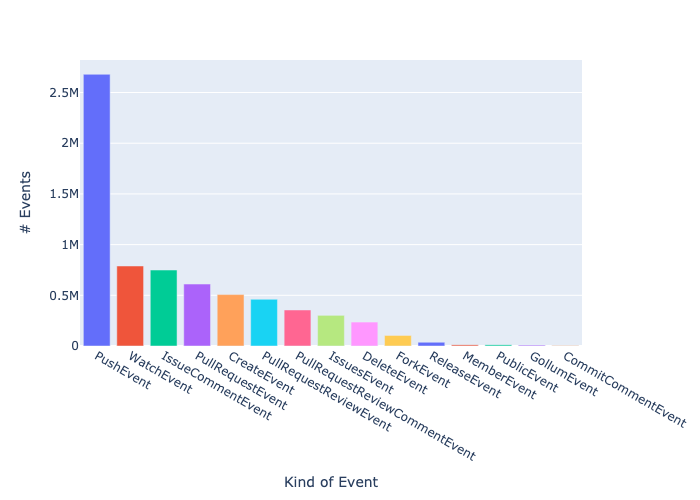

In [10]:
Image("general_eventcount.png")

### Repositories with the most events 

In [11]:
repo_event_counts = df_event_stream.repo_git.value_counts()
repo_event_counts

repo_git
https://api.github.com/repos/pytorch/pytorch                          64253
https://api.github.com/repos/llvm/llvm-project                        18243
https://api.github.com/repos/huggingface/transformers                 16758
https://api.github.com/repos/vllm-project/vllm                        14075
https://api.github.com/repos/langchain-ai/langchain                   13835
                                                                      ...  
https://api.github.com/repos/xinntao/ProjectTemplate-Python               1
https://api.github.com/repos/Abonaventure/ORB_SLAM3_AR-for-Android        1
https://api.github.com/repos/zhaoxuhui/ORB-Code-Notes                     1
https://api.github.com/repos/nik-suri/keplr-chain-registry                1
https://api.github.com/repos/StarlangSoftware/TurkishWordNet-Py           1
Name: count, Length: 549262, dtype: int64

Let's generate a bar chart that visualizes the number of events associated with different repositories. This chart is particularly focused on repositories with more than 2,500 events, filtering out those with fewer events to highlight the most active repositories.

- Data: The data is first processed by renaming the column in the `repo_event_counts` DataFrame to count. Then, it filters the repositories to include only those with more than 2,500 events.
- Color Encoding: Each bar is colored based on the repository name, providing a visual distinction between different repositories.

In [12]:
df_fig_rec = repo_event_counts.to_frame().rename(columns={"repo_git": "count"})
print(df_fig_rec)
df_fig_rec = df_fig_rec[df_fig_rec["count"] > 2500]

fig_rec = px.bar(
    data_frame=df_fig_rec,
    color=df_fig_rec.index,
)
fig_rec.update_layout(showlegend=False)
fig_rec.write_image("general_repository_eventcount.png")
fig_rec

                                                    count
repo_git                                                 
https://api.github.com/repos/pytorch/pytorch        64253
https://api.github.com/repos/llvm/llvm-project      18243
https://api.github.com/repos/huggingface/transf...  16758
https://api.github.com/repos/vllm-project/vllm      14075
https://api.github.com/repos/langchain-ai/langc...  13835
...                                                   ...
https://api.github.com/repos/xinntao/ProjectTem...      1
https://api.github.com/repos/Abonaventure/ORB_S...      1
https://api.github.com/repos/zhaoxuhui/ORB-Code...      1
https://api.github.com/repos/nik-suri/keplr-cha...      1
https://api.github.com/repos/StarlangSoftware/T...      1

[549262 rows x 1 columns]


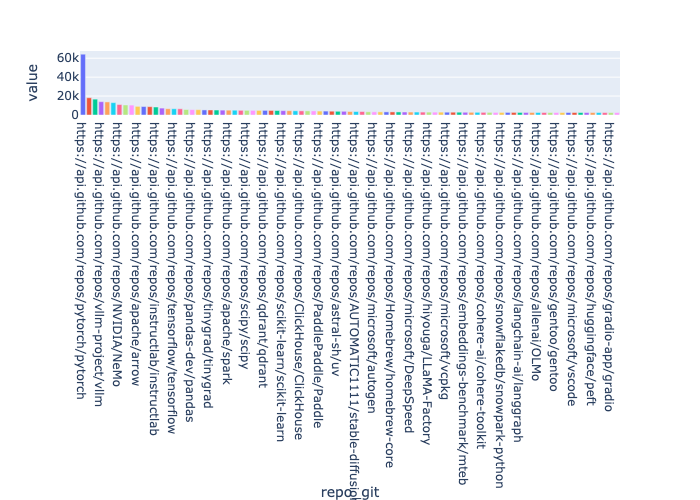

In [13]:
Image("general_repository_eventcount.png")

## Known Contributors Event Stream Analysis

We'd like to know which projects our group of contributors are the most active in. 

We'll cross-reference our event stream with the list of contributor IDs we have from our previous analysis.

In [14]:
UUID_known = df_known_contribs.cntrb_id.to_list()
UUID_known[:10]

['010000b0-0f00-0000-0000-000000000000',
 '01000180-1a00-0000-0000-000000000000',
 '01012f1b-7f00-0000-0000-000000000000',
 '010000b4-3700-0000-0000-000000000000',
 '010000f0-9200-0000-0000-000000000000',
 '010000f2-1900-0000-0000-000000000000',
 '01002fb3-e600-0000-0000-000000000000',
 '0103ea29-8e00-0000-0000-000000000000',
 '01000117-3e00-0000-0000-000000000000',
 '0100012d-d800-0000-0000-000000000000']

In [15]:
# only consider events from known contributors.
df_known_event_stream = df_event_stream[df_event_stream.cntrb_id.isin(UUID_known)]

### Difference in size:

The initial set of events represented the activity of the population of all Github users. 

By filtering by `UUID_known`, we now consider only those events from those contributors that we identified in our previous step; those that were in the initial set of repos that we believe are in our ecosystem of interest.

This change is from `6.8` Million events to `533K` events, nearly an order of magnitude difference.

In [16]:
print(f"Diff in size: {df_event_stream.shape} compared to {df_known_event_stream.shape}")

Diff in size: (6868909, 8) compared to (533785, 8)


### Most common events among known contributors

### General Event Count Bar Chart
Let's generate a bar chart that visualizes the frequency of different event types using Plotly Express. The chart is created from a DataFrame, `df_known_event_stream` containing event counts, with the event types represented on the x-axis and the number of occurrences on the y-axis.

- Data Source: The data used in this bar chart is derived from the `df_known_event_stream` DataFrame.
- Color Encoding: Each bar is colored based on the event type, allowing for easy differentiation between different types of events.
- Labels: The y-axis is labeled as # Events, representing the count of each event type, and the x-axis is labeled as Kind of Event to specify the types of events being counted.

In [17]:
kc_event_counts = df_known_event_stream.event_type.value_counts()
fig_kec = px.bar(
    data_frame=kc_event_counts.to_frame(),
    color=kc_event_counts.to_frame().index,
    labels={
                     "value": "# Events",
                     "event_type": "Kind of Event"
                 },
)
fig_kec.update_layout(showlegend=False)
fig_kec.write_image("knowncontributors_eventcount.png")
fig_kec

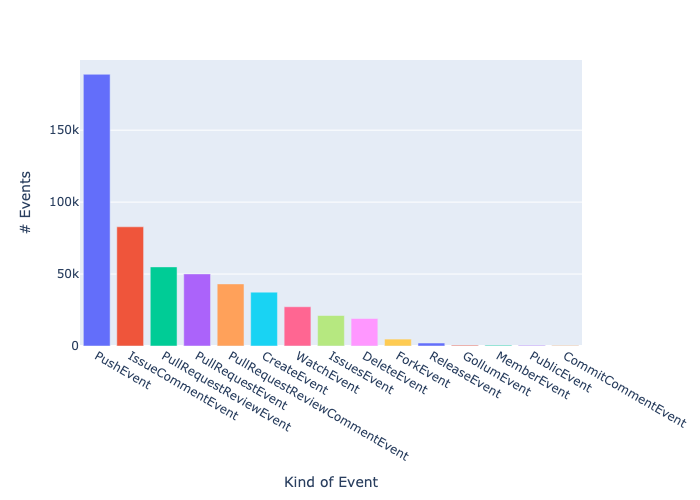

In [18]:
Image("knowncontributors_eventcount.png")

### Most common repositories among known contributors

Let's create a bar chart that visualizes the number of events contributed by known contributors to various repositories. The chart displays the top 50 repositories based on the number of contributor events. We are considering top 50 repositories based on the number of events as they have good number of events.

- Data Source: The data is sourced from the `kc_repo_event_counts` DataFrame, which counts the number of events associated with each repository URL contributed by known contributors.
- Color Encoding: Each bar is colored according to the repository URL, making it easy to distinguish between different repositories.
- Labels: The y-axis is labeled as `# Contributor Events`, representing the count of events per repository, and the x-axis is labeled as `Repository URL` to identify the repositories.

In [19]:
kc_repo_event_counts = df_known_event_stream.repo_git.value_counts()
df_fig_rec_kc = kc_repo_event_counts.to_frame() 

fig_rec_kc = px.bar(
    data_frame=df_fig_rec_kc[:50],
    color=df_fig_rec_kc[:50].index,
    labels={
                    "value": "# Contributor Events",
                    "repo_git": "Repository URL"
                },
)
fig_rec_kc.update_layout(showlegend=False)
fig_rec_kc.write_image("knowncontributors_repository_eventcount.png")
fig_rec_kc

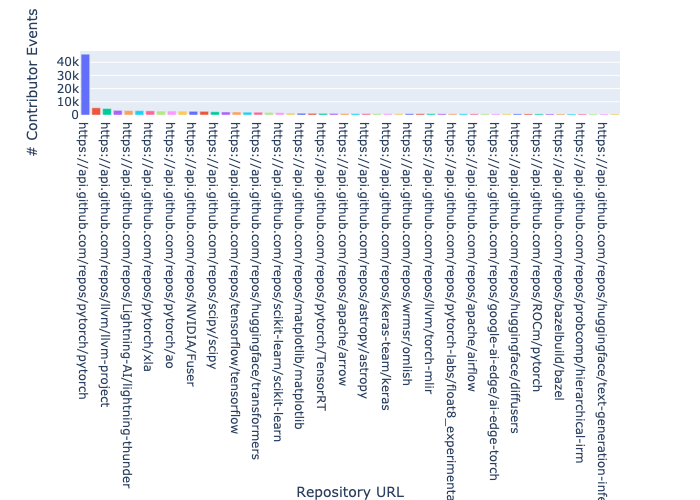

In [20]:
Image("knowncontributors_repository_eventcount.png")

## Interpretation

We find here that some obvious WASM-specific repositories are contributed to most frequently by the contributors we already knew about.

However, as one might expect, repos that are popular among the general public like 'risingwavelabs/risingwave', (which is 5th in this list and 74th among the general population, despite being a distributed streaming DB (not about WASM))
are also popular among this slice of the general population.

Our challenge now is to find those repos that are *especially* popular among this population as compared to the popularity among the general public.

# Identify disproportionately popular repos

## Unknown contributors

We want to consider the popularity of repos among people who aren't in our initial set.

If our 'known' group of contributors is the subpopulation "p" and the general population is "P", then the group of people who are in the general population but aren't in our sub-population is "P - p" or $\hat{P}$, pronounced P-hat.



Hence, $\hat{P}$ would be our unknown contributors.

In [36]:
# Get events made by those in P^

df_general_event_stream = df_event_stream[~df_event_stream.cntrb_id.isin(UUID_known)]
df_general_event_stream.shape

(6335124, 8)

In [22]:
# Count the events-per-repo of P^

g_repo_event_counts = df_general_event_stream.repo_git.value_counts().to_frame()
g_repo_event_counts

,count
repo_git,
https://api.github.com/repos/pytorch/pytorch,18197
https://api.github.com/repos/huggingface/transformers,14637
https://api.github.com/repos/langchain-ai/langchain,13750
https://api.github.com/repos/llvm/llvm-project,13325
https://api.github.com/repos/vllm-project/vllm,11306
...,...
https://api.github.com/repos/Xingyu-Lin/VCD,1
https://api.github.com/repos/r-lib/debugme,1
https://api.github.com/repos/noahewolfe/jax-tqdm,1


Let's combine two sets of counts — one for a general population and another for a specific sub-population—into $\hat{P}$ a single DataFrame. Perform left join, ensuring that all data from the general population is preserved, and rename columns for clarity, and fill any missing data with zeros. The result is a DataFrame where each row represents an entity (like a repository) with its counts from both the general population and the sub-population.

In [23]:
# Join the counts of P^ with those of p

joined_counts = g_repo_event_counts.join(
    other=kc_repo_event_counts.to_frame(),
    how="left",
    lsuffix="_general",
    rsuffix="_known",
)

joined_counts = joined_counts.rename(columns={"repo_git_general": "count_general", "repo_git_known": "count_known"})
joined_counts = joined_counts.fillna(0)
joined_counts

,count_general,count_known
repo_git,,
https://api.github.com/repos/pytorch/pytorch,18197,46056.0
https://api.github.com/repos/huggingface/transformers,14637,2121.0
https://api.github.com/repos/langchain-ai/langchain,13750,85.0
https://api.github.com/repos/llvm/llvm-project,13325,4918.0
https://api.github.com/repos/vllm-project/vllm,11306,2769.0
...,...,...
https://api.github.com/repos/Xingyu-Lin/VCD,1,0.0
https://api.github.com/repos/r-lib/debugme,1,0.0
https://api.github.com/repos/noahewolfe/jax-tqdm,1,0.0


## Simple approach

In this figure we visualize the count of contributions from those in 'p' and $\hat{P}$ stacked on top of one another. 

Most of the most-contributed-to projects of those in 'p' are also most-contributed-to by members of 'p' (they are not also largely contributed to by those in $\hat{P}$).

Some notable visual exceptions are `llvm/llvm-project`, `NixOS/nixpkgs`, `python/cpython`, `huggingface/transformers` and `apache/arrow`.

In [24]:
fig_joined_counts = px.bar(
    data_frame=joined_counts
    .sort_values(by="count_known", ascending=False) # sort the joined_counts df by the number of contributions made by those in p
    [:50], # only take the first 50
    y=["count_general", "count_known"],
    labels={
                    "value": "# Contributor Events",
                    "repo_git": "Repository URL"
                },
)
fig_joined_counts.update_layout(showlegend=False)
fig_joined_counts.write_image("joined_counts.png")
fig_joined_counts

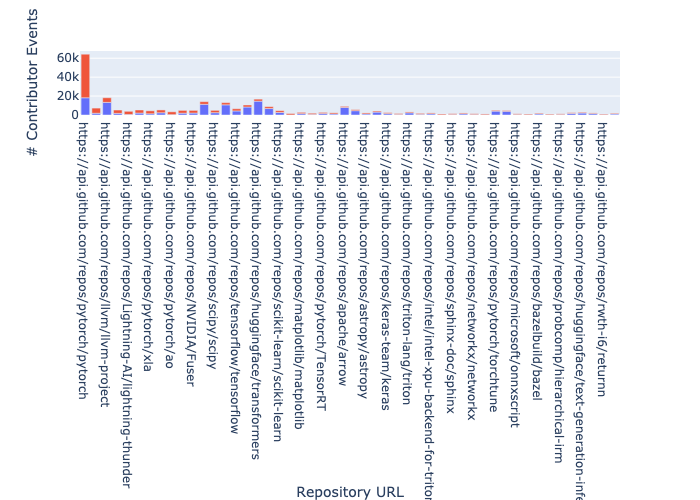

In [25]:
Image("joined_counts.png")

## Interpretation

Above, the Red parts of the bars represent the count of events from our known population 'p', whereas the Blue parts of the stacks represent the complementary population $\hat{P}$.

From left to right, descending, are the projects with the largest number of contribution events (number of contribution events) from people in 'p'.

The people from our subpopulation should 100% dominate projects like Wasmer and Wasmedge, because those are among the populations whose population we're directly considering.
(wasmedge, wavm, wasmtime, wasmr are the repos we're pulling from). Interestingly though, we also see that the same group of people dominate other, non-WASM projects like risingwave, noir, and mathlib4.

This opens an interesting new line of inquiry. If the overlap of contributors between projects was extremely ecosystem-specific, e.g. people from WASMedge MOSTLY participated in WASM related projects,
then we could easily start with any WASM project and find those projects with greatest contributor overlap, and identify that those are all the WASM projects. 

However, this isn't the case- people who are participating in WASM are also participating in non-WASM projects, and they're contributing in high volumes, 'dominating' those projects w.r.t the population 'P^'.

## Conclusion

There isn't free lunch here. We need to use more sensitive methods to 'sniff out' WASM-related repositories, considering not only WHO is contributing WHERE, but who their social network is and
what their behavior is within the 'seed' communities we start with.


## Implement alpha and beta indices of preference

Mathematical definition of following approach:

https://www.overleaf.com/read/hxnsqsydqcrw#f624f4

### Implement alpha

'alpha' is a probablistic contribution metric. It captures 'how much more or less likely' the subpopulation 'p' is to contribute to a repository relative to the general population 'P^'.

More details can be found in the overleaf document referenced at the top of this section.

In [26]:
# probabilities of contribution in known population

# number of contribution events by our contributor subpopulation
n_known = joined_counts["count_known"].sum()

# divide the per-repo contribution count by the total num of contributions by population.
# this is interpretateable as "the probability that the subpopulation will contribute to a given repo"
joined_counts["p_known"] = joined_counts["count_known"] / n_known
joined_counts

,count_general,count_known,p_known
repo_git,,,
https://api.github.com/repos/pytorch/pytorch,18197,46056.0,0.131437
https://api.github.com/repos/huggingface/transformers,14637,2121.0,0.006053
https://api.github.com/repos/langchain-ai/langchain,13750,85.0,0.000243
https://api.github.com/repos/llvm/llvm-project,13325,4918.0,0.014035
https://api.github.com/repos/vllm-project/vllm,11306,2769.0,0.007902
...,...,...,...
https://api.github.com/repos/Xingyu-Lin/VCD,1,0.0,0.000000
https://api.github.com/repos/r-lib/debugme,1,0.0,0.000000
https://api.github.com/repos/noahewolfe/jax-tqdm,1,0.0,0.000000


In [27]:
# Probabilities of contribution in general population:

# number of contribution events by the general population.
n_general = joined_counts["count_general"].sum()

# divide the per-repo contribution count by the total num of contributions by general population.
# this is interpretateable as "the probability that the general population will contribute to a given repo"
joined_counts["p_everyone"] = (joined_counts["count_general"] + joined_counts["count_known"]) / (n_general + n_known)
joined_counts

,count_general,count_known,p_known,p_everyone
repo_git,,,,
https://api.github.com/repos/pytorch/pytorch,18197,46056.0,0.131437,9.610759e-03
https://api.github.com/repos/huggingface/transformers,14637,2121.0,0.006053,2.506608e-03
https://api.github.com/repos/langchain-ai/langchain,13750,85.0,0.000243,2.069395e-03
https://api.github.com/repos/llvm/llvm-project,13325,4918.0,0.014035,2.728730e-03
https://api.github.com/repos/vllm-project/vllm,11306,2769.0,0.007902,2.105294e-03
...,...,...,...,...
https://api.github.com/repos/Xingyu-Lin/VCD,1,0.0,0.000000,1.495768e-07
https://api.github.com/repos/r-lib/debugme,1,0.0,0.000000,1.495768e-07
https://api.github.com/repos/noahewolfe/jax-tqdm,1,0.0,0.000000,1.495768e-07


In [28]:
# calculate alpha

# by what factor is the subpopulation more or less likely to contribute to a repo?
joined_counts["alpha"] = joined_counts["p_known"] / joined_counts["p_everyone"]
joined_counts

,count_general,count_known,p_known,p_everyone,alpha
repo_git,,,,,
https://api.github.com/repos/pytorch/pytorch,18197,46056.0,0.131437,9.610759e-03,13.676012
https://api.github.com/repos/huggingface/transformers,14637,2121.0,0.006053,2.506608e-03,2.414822
https://api.github.com/repos/langchain-ai/langchain,13750,85.0,0.000243,2.069395e-03,0.117221
https://api.github.com/repos/llvm/llvm-project,13325,4918.0,0.014035,2.728730e-03,5.143502
https://api.github.com/repos/vllm-project/vllm,11306,2769.0,0.007902,2.105294e-03,3.753541
...,...,...,...,...,...
https://api.github.com/repos/Xingyu-Lin/VCD,1,0.0,0.000000,1.495768e-07,0.000000
https://api.github.com/repos/r-lib/debugme,1,0.0,0.000000,1.495768e-07,0.000000
https://api.github.com/repos/noahewolfe/jax-tqdm,1,0.0,0.000000,1.495768e-07,0.000000


In [29]:
joined_counts.sort_values(by=["alpha"], ascending=False)

,count_general,count_known,p_known,p_everyone,alpha
repo_git,,,,,
https://api.github.com/repos/NoteDance/Note,1,571.0,0.001630,8.555794e-05,19.046130
https://api.github.com/repos/JuliaDynamics/DynamicSumTypes.jl,1,478.0,0.001364,7.164730e-05,19.039653
https://api.github.com/repos/SkyblockerMod/Skyblocker,1,389.0,0.001110,5.833496e-05,19.030564
https://api.github.com/repos/PTB-MR/mrpro,1,381.0,0.001087,5.713834e-05,19.029539
https://api.github.com/repos/durandtibo/grizz,1,327.0,0.000933,4.906120e-05,19.021316
...,...,...,...,...,...
https://api.github.com/repos/amitt1236/Gaze_estimation,4,0.0,0.000000,5.983073e-07,0.000000
https://api.github.com/repos/ClaudeCoulombe/EcorcIA_Application_Mobile,4,0.0,0.000000,5.983073e-07,0.000000
https://api.github.com/repos/stefanprobst/get-tsconfig,4,0.0,0.000000,5.983073e-07,0.000000


Those repos that our subcommunity dominates (those that they own) are ~17x more likely to be contributed to (naturally) than by the general population.

e.g. for 'moondance-labs/tanssi', |p|=683 and |P^|=1, so the probability that the subpopulation contributes to this particular project is measured as significantly higher than the general population.

However, 683 events still isn't many relative to the number of events we observe for large projects (9443 for apple/swift), so this isn't a terribly strong indication that the project is 'important' to the WASM ecosystem in general.

In [30]:
# visualize alpha scores

fig = px.bar(
    data_frame = joined_counts.sort_values(by="alpha", ascending=False)[:100],
    y="alpha",
    custom_data=["count_known", "count_general"]
)
fig.update_traces(hovertemplate = "Repo:%{label}: <br>Alpha: %{value} </br>(count_known, count_general) : %{customdata}"
)
fig.write_image("alpha_scores.png")
fig

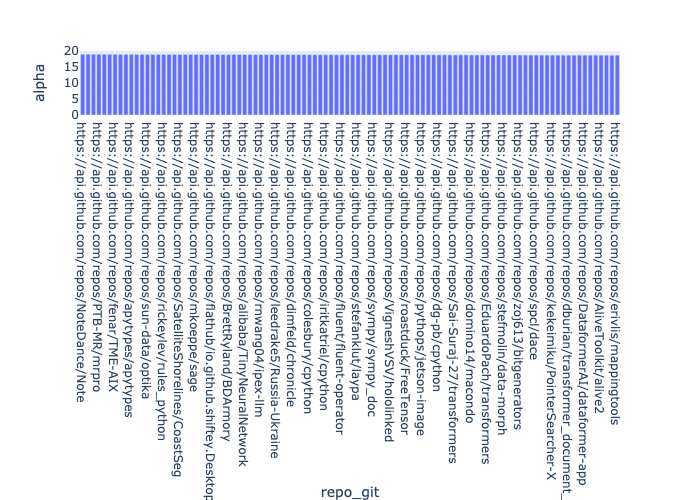

In [31]:
Image("alpha_scores.png")

To understand this graph, let's take a given alpha value and interpret it.

For moondance-labs/tanssi, the alpha value is 16.93 - we can interpret this value as "Members of the subpopulation 'p' are 16.9x more likely to contribute to this repository than members of the general population 'P^' are."

Most of the alpha values we see in this top-100 alpha values plot are similar enough that the graph looks flat, but they're all slightly different values, based on count_general and count_known.

Observing the top 1000 repos by alpha value, the alpha value decreases fairly steadily without major outliers.

### Implement beta

'beta' attempts to connect the probablistic metric that 'alpha' provides to the real volume of contribution events that a repo experiences. The number of events is log-scaled so that orders-of-magnitude differences are smoothed out.

Ideally, 'beta' allows us to see which repos are not only disproportionately 'popular' among the subpopulation (which can be biased toward projects that are ONLY contributed to by our subpopulation) but are also GENERALLY seeing lots of work being done.

In [32]:
# take the log of the count of known contributors.
# This reduces the impact of very high contribution volume, shifting the 
# impact toward the alpha value.

joined_counts["log_count_known"] = joined_counts["count_known"].apply(lambda x: math.log(x) if x>0 else 0)

In [33]:
joined_counts["beta"] = joined_counts["alpha"] * joined_counts["log_count_known"] 
joined_counts[:10]

,count_general,count_known,p_known,p_everyone,alpha,log_count_known,beta
repo_git,,,,,,,
https://api.github.com/repos/pytorch/pytorch,18197,46056.0,0.131437,0.009611,13.676012,10.737613,146.847725
https://api.github.com/repos/huggingface/transformers,14637,2121.0,0.006053,0.002507,2.414822,7.659643,18.496675
https://api.github.com/repos/langchain-ai/langchain,13750,85.0,0.000243,0.002069,0.117221,4.442651,0.520773
https://api.github.com/repos/llvm/llvm-project,13325,4918.0,0.014035,0.002729,5.143502,8.500657,43.723148
https://api.github.com/repos/vllm-project/vllm,11306,2769.0,0.007902,0.002105,3.753541,7.926242,29.751476
https://api.github.com/repos/NVIDIA/NeMo,10834,229.0,0.000654,0.001655,0.394938,5.433722,2.145985
https://api.github.com/repos/NixOS/nixpkgs,10746,2306.0,0.006581,0.001952,3.370923,7.743270,26.101970
https://api.github.com/repos/milvus-io/milvus,10474,13.0,0.000037,0.001569,0.023652,2.564949,0.060665
https://api.github.com/repos/run-llama/llama_index,8873,86.0,0.000245,0.001340,0.183149,4.454347,0.815811


In [34]:
fig = px.bar(
    data_frame=joined_counts.sort_values(by="beta", ascending=False)[:100],
    y="beta",
    hover_data=["alpha", "log_count_known", "count_known", "count_general"]
)
fig.write_image("beta_scores.png")
fig

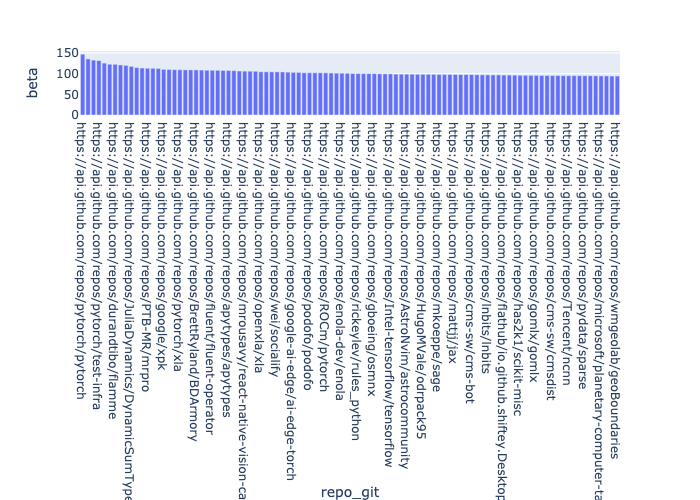

In [35]:
Image("beta_scores.png")

'beta' as a raw number is fairly arbitrary, but as a relative value, it lends to an informative comparison between projects.

'Higher' beta values "score better" w.r.t popularity and contribution volume from contributors, while 'lower' values are likely lower in contribution volume or in proportional popularity than their peer projects.
The balance between the impact of these two considerations deserves significant refinement, and is an opportunity for further work.

Nevertheless, we can see above that "WASM-y" projects have the highest 'beta' values for our subpopulation of interest, including some that we didn't have in our 'kernel' group of projects.

## Takeaway

Top repos by 'beta' value are:

- risingwave
- wasmer
- cosmwasm
- wasmtime
- ppsspp
- tigerbeetle
- ion-rust
- redash
- Ambient
- rspack
- socket
- runwasi
- holochain

Many of these are very directly connected to WASM, while others (risingwave, tigerbeetle, redash, holochain, ppsspp) are relatively unrelated.

This demonstrates that simply considering the contribution-base of our sub-population will yield strong cross-pollination signal. We need to be considerate of ecosystem-specific features when selecting our contributor set in order to clarify the ecosystem discovery signal.

### Next step

Top repos by 'beta' are similar to those by 'alpha.' 

The distribution of projects seems to have some scew toward database systems and no-trust mathematical proofs. This probably represents the interest-space of contributors within the WASM space, which itself is fairly experimental.

The next logical step is to renew focus on the 'core' contributors of the collaboration network, weighing the contributions of those people highly because they're highly integrated in the world of WASM.

# Conclusion

The alpha and beta metrics proposed in this work attempt to inspect the distinction between projects that are 'popular' within a subgroup working on an ecosystem of interest
and those that are 'massively contributed to.' A project might be very popular numerically within a subpopulation because they're the exclusive contributors to that project,
but the amount of work being done might be comparatively low. Likewise, a project could be astonomically interesting to the general population, and thereby interesting to many people
within our subpopulation, but be RELATIVELY less interesting compared to other projects that our subpopulation is working on.

This notebook applies alpha and beta to the behavior of our subgroup and identifies projects that are both popular and largely contributed to by our subpopulation of interest.

Notably, we can see that the "most popular" general project, LLVM, is not present in the 'top repos by beta value', but projects that are very WASM-y and previously unknown are included,
such as cosmwasm and runwasi.

## Further Work

These results are interesting but they further substantiate that count-based identification of repositories within an ecosystem is a weak signal at best.
Future work should look beyond simply "counting people" and "counting contribution events."